# 학습 목표
**적대적 예제** : 머신러닝 모델에게 착시를 유도하는 입력

적대적 예제를 생성해서 여러 가지 머신러닝 기반 시스템의 성능을 의도적으로 떨어뜨려 보안 문제르르 일으키는 **적대적 공격**에 대해 알아보자!

# 목차
- 적대적 공격이란?
- 적대적 공격의 종류
- FGSM 공격

### 8.1 적대적 공격이란?

복잡한 딥러닝 모델을 속이는 데 복잡한 기술이 필요하지 않다. 

자율주행, 은행 비정상거래탐지, 의료영상분석 등 실수가 용납되지 않는 분야의 시스템에 신뢰도를 떨어뜨리는 약점이 존재한다는 것은 치명적이다.

컴퓨터를 해킹하는 방법이 다양하 듯 적대적 공격도 여러 종류가 있다. 대표적인 몇 개 알아보자.

---

### 8.2 적대적 공격의 종류

적대적 공격은 노이즈를 생성해 사람 눈엔 똑같이 보이지만, 머신러닝 모델을 헷갈리게 만드는 적대적 예제를 생성하는 것이 핵심이다.

인식 오류를 일으키지만 원본과 차이가 가장 적은 잡음 찾기 -> 최적화 문제

오차를 줄이기보다는 극대화하는 쪽으로 잡음을 최적화 한다...고 하는데 오차를 극대화하는 것과 잡음을 최적화 한다는 말의 정확한 의미가 이해가 안돼서 찾아봤다.

> 📌 오차를 최적화 한다? 의 의미 찾아보기
> https://datascienceschool.net/02%20mathematics/05.01%20%EC%B5%9C%EC%A0%81%ED%99%94%20%EA%B8%B0%EC%B4%88.html



#### 6.2.2 잠재 변수 들여다보기
학습 완료된 오토인코더에서 나온 잠재 변수들이 3차원에서 어떻게 분포되는지 알아보기.

잡음을 생성하는 방법은 매우 많다. 적대적 예제에서 잡음의 생성 방법은 **분류 기준**이 무엇이냐에 따라 나뉘는데 대표적인 분류 기준은 다음과 같다.
![잡음 분류 기준 및 예시](https://github.com/kjsoo-1010/pytorch_deeplearning/blob/main/8_noise_type.png?raw=true)


가장 강력한 공격 방법은 
1. 모델 정보가 필요 없고
2. 원하는 정답으로 유도할 수 있고
3. 복잡한 학습이 필요하지 않으며
4. 여러 모델에 동시에 적용할 수 있는 방법
이지만, 각 특징에는 기회비용이 존재한다.

예시로 여러 모델에 동시에 어떤 답을 유도하게 하는 강력한 공격을 하고 싶다고 가정할 때, 이 공격을 수행하려면 모델에 대한 **정보가 많을수록** 좋고, 모델의 정보를 이용하더라도 **복잡한 최적화 과정**을 거치지 않으면 힘들다는 것을 알 수 있다.

---

### 8.3 FGSM 공격
- **FGSM**(=Fast Gradient Sign Method)는 반복된 학습 없이 잡음을 생성하는 원샷 공격. 입력 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성한다.

잡음이 보이지 않아야하므로 아주 작은 숫자(아래 예시에선 0.007)를 곱해서 희석한 후 원본 그림에 더한다.

![적대적 예제가 만들어지는 과정](https://github.com/kjsoo-1010/pytorch_deeplearning/blob/main/8_FGSM_example_panda.png?raw=true)

최적화를 반복하여 더 정교한 잡음을 만들 수도 있다.

FGSM은 공격 목표를 정할 수 없는 **non-targeted** 방식이자, 대상 모델의 정보가 필요한 **화이트박스** 방식이다.

In [2]:
# 필수 라이브러리 import
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json
import matplotlib.pyplot as plt

#### 8.3.1 학습된 모델 불러오기
사용할 모델을 가져오는 `model.<모델명>` 함수를 호출할 때 인수로 `pretrained = True`를 명시하면 학습이 완료된 모델을 사용할 수 있다.

이번에 사용할 모델은 **ResNet101**이다.

In [3]:
model = models.resnet101(pretrained = True)
model.eval()

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

실제 모델의 예측값을 보면 0부터 1000까지의 숫자만 내뱉는데 이는 이미지넷 데이터셋의 클래스를 가리키는 번호이다. 이 숫자를 클래스 이름과 이어주는 작업이 필요하다.
1. 숫자와 클래스 제목의 매칭 정보가 담겨있는 파일을 불러와 딕셔너리로 만들고
2. 번호를 레이블 이름으로 변환해주는 `idx2class` 리스트를 생성하자

In [4]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

#### 8.3.2 공격할 이미지 불러오기
실제 공격은 학습용 데이터에 존재하지 않는 이미지로 가해질 것이므로 데이터셋에 존재하지 않는 이미지를 새로 준비해와야한다.

이미지넷 데이터셋에는 펨브로크 웰시코기라는 클래스가 존재한다. 여기에 다른 웰시코기 사진을 추가하여 진행해보자.

이미지 크기는 `transforms`를 사용하여 이미지넷과 같은 크기인 224 x 224 로 바꾸고 파이토치 텐서로 변환하는 기능을 추가하여 `img_transforms`를 통과시키면 어떤 이미지라도 입력으로 사용할 수 있다.

마지막으로 `unsqueeze(0)` 함수로 3x224x224 의 이미지를 1x3x224x224 로 batch 를 나타내는 차원을 하나 추가해준다.

In [6]:
# 새로운 웰시코기 이미지 불러오기
img = Image.open("imagenet_samples/corgie.jpg")

# 이미지를 텐서로 변환
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)

print("이미지 텐서 모양: ", img_tensor.size())

이미지 텐서 모양:  torch.Size([1, 3, 224, 224])


C:\Users\Administrator\AppData\Local\Temp\ipykernel_29564\3018009341.py:6: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  transforms.Resize((224, 224), Image.BICUBIC),
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


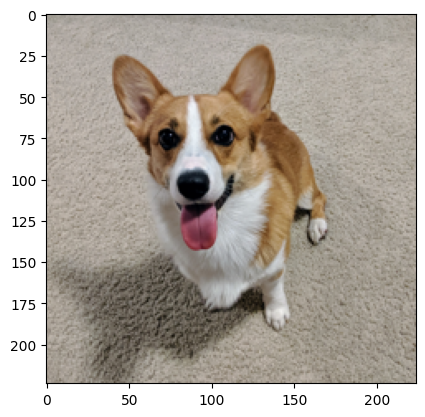

In [7]:
# 시각화를 위해 넘파이 행렬 변환
# [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.transpose(0, 2).transpose(0, 1).numpy()

plt.imshow(original_img_view)

> 📌 `detach()` 함수 찾아보기
>
> 참고 링크 
>
> : [복사의 수많은 방법 : detach() & clone() * .data](https://subinium.github.io/pytorch-Tensor-Variable/#%EB%B3%B5%EC%82%AC%EC%9D%98-%EC%88%98%EB%A7%8E%EC%9D%80-%EB%B0%A9%EB%B2%95--detach--clone--data), [tensor.detach() 의 기능과 예시 코드](https://bo-10000.tistory.com/181) 

> 📌 `transpose`
>
> 보통 (batch_size, hidden_dim, input_dim) 을 (batch_size, input_dim, hidden_dim) 으로 바꿔주는 작업을 할 때에 transpose 를 사용한다.
>
> [참고 링크](https://inmoonlight.github.io/2021/03/03/PyTorch-view-transpose-reshape/)


#### 8.3.3 공격 전 성능 확인하기
모델에 이미지를 통과시키고, 나온 값에 `max()` 함수를 사용하여 확률이 가장 높은 인덱스를 가져올 수 있다.

In [10]:
output = model(img_tensor)
prediction = output.max(1, keepdim = False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호 : ", prediction_idx)
print("레이블 이름 : ", prediction_name)

예측된 레이블 번호 :  263
레이블 이름 :  Pembroke, Pembroke Welsh corgi


#### 8.3.4 FGSM 공격 함수 정의
FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본 이미지에 더하는 것이다. -> 기울기 = 모델이 학습할 때 각 픽셀이 미치는 영향.

원본 이미지를 받아 적대적 예제를 생성하는 `fgsm_attack()` 함수를 정의해보자.

모델을 헷갈리게 하려면 **모델의 오찻값을 극대화** 해야한다.

=> 애매하게 헷갈리게 하면 별 소용없으니까 엄청 잘못 생각하게 해야 먹힌다.


딥러닝 모델을 **학습할 때**는 기울기의 정반대 편으로 가중치를 조절하며 오차를 줄였는데, FGSM 공격에선 반대로 잡음이 기울기의 방향으로 최적화하도록 해서 오차를 키워야한다.

-> 기울기의 방향성을 알 수 있도록 `sign()` 함수 사용.

sign() 함수는 입력이 0보다 작으면 -1을, 0이면 0을, 0보다 크면 1을 출력한다.

그리고 가장 작은 값인 앱실론을 곱해준다. 앱실론은 모델 학습 시 지정해줘야 하는 학습률과 같은 개념으로 잡음이 너무 커지지 않고 사람의 눈에 보이지 않게 제한하는 역할이다.

결과적으로
1. 이미지의 기울기 방향이 양수인 곳에 앱실론만큼 값을 증가시키고
2. 음수인 곳은 앱실론만큼 감소시킨다.

In [17]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign값을 구함
    sign_gradient = gradient.sign()
    # 이미지의 각 픽셀값을 sign_gradient 방향으로 epsilon만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0 ,1] 범위를 벗어나는 값 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

#### 8.3.5 적대적 예제 생성

순서
1. 이미지를 텐서 만들었고
2. 모델에 돌렸을 때 기울기 값이 얼마인지 확인하고
3. 기울기값 방향 확인해서 앱실론만큼 조절한 다음에
4. 이미지랑 합쳐준다.

In [18]:
# 이미지의 기울기를 구하도록 설정
img_tensor.requires_grad_(True)
# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오찻값 구하기
loss = F.nll_loss(output, torch.tensor([263]))

# 기울기 구하기
model.zero_grad()
loss.backward()

In [19]:
# 이미지 기울기 '추출'해오기
# 2번에 해당.
gradient = img_tensor.grad.data

# FSGM 공격으로 적대적 예제 생성
# 3번과 4번에 해당.
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

In [20]:
# 생성된 적대적 예제 모델에 통과시킴
output = model(perturbed_data)

#### 8.3.6 적대적 예제 성능 확인
적대적 예제 통과시킨 모델 예측 결과를 확인해보자.

In [21]:
perturbed_prediction = output.max(1, keepdim = False)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호 : ", perturbed_prediction_idx)
print("레이블 이름 : ", perturbed_prediction_name)

예측된 레이블 번호 :  172
레이블 이름 :  whippet


아까와는 다른 결과가 나왔다. 휘핏이라는 강아지 종이 나왔고, 그럼 이 적대적 예제가 어떻게 생겼는지 확인하여 비교해보자.

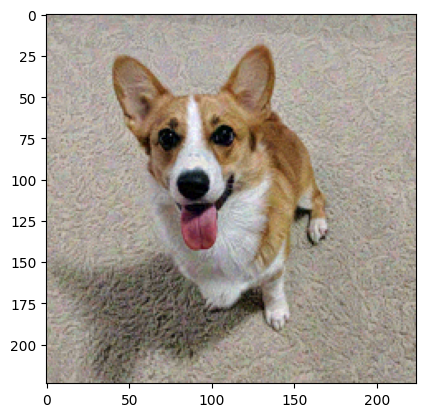

In [22]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

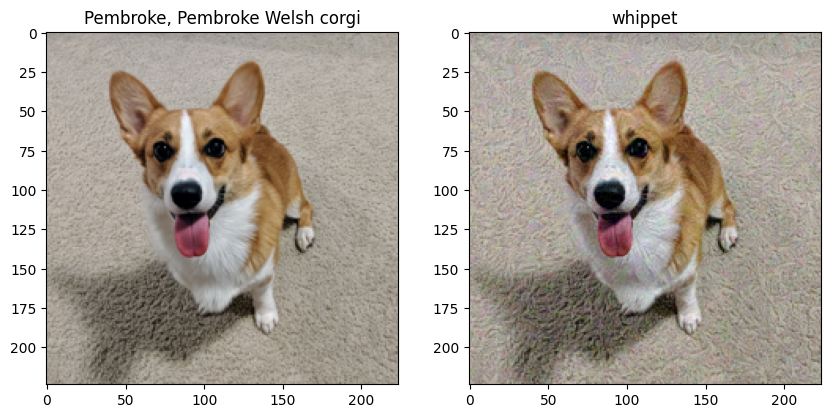

In [23]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()

육안으로 보기엔 거의 유사하나 딥러닝의 약점을 공략하여 만든 결과이다.

적대적 예제를 생성하는 각종 방법에 대한 연구도 진행되고 있지만, 이를 방어하는 연구도 활발히 진행되고 있다고 한다.